In [25]:
import numpy as np
import scipy.optimize as optimize
import copy
import matplotlib.pyplot as plt

In [89]:
# The final product function
# Inputs:
#    - func: a function handle to the function that you want to minimize
#    - x0: an initial guess
#    - tol: the tolerance level that you want to converge to
#
# Outputs:
#    - xstar: the optimal x-values
#    - fstar: the optimal function value

def NelderMead(obj,x0,tol = 1e-6,maxIter = 1000,commentary = False,showxstar = False,TriangleOpsShow = False,startingPointsStep = 1):
    
    # Define the starting points (tetrahedron)
    points = defineStartingPoints(x0,startingPointsStep)
    
    for i in range(0,maxIter):
        
        # Order points
        orderedPoints, orderedValues = orderPoints(obj,points)
        
        # Get centroid
        centroid = getCentroid(orderedPoints)
        
        # Get next triangle
        newPoints, method = getNextTriangle(obj,orderedPoints,orderedValues,centroid,TriangleOpsShow)
        
        # Check convergence criteria
        converged,norm = checkConvergence(newPoints,orderedPoints,tol)
        
        if commentary:
            print("Iteration:",i+1,"\tf(x) =","{:.5e}".format(obj(newPoints[:,0])),"\tNorm:","{:.5e}".format(norm),"\tMethod:",method)
            if showxstar:
                print("\tCurrent x* value: ",newPoints[:,0])
                print(" ")
        
        if converged:
            print(" ")
            print("Optimization comlete.")
            
            break
        else:
            points = newPoints
            
    xstar = newPoints[:,0]
    fstar = obj(xstar)
    print("Iterations:",i + 1)
    print("Norm:",norm)
    print("Function Value:",fstar)
    print("Optimal Inputs:",xstar)
            
    return xstar, fstar
        
        
def defineStartingPoints(x0,step):
    
    n = len(x0)
    
    startingPoints = np.zeros((n,n+1))
    startingPoints[:,0] = x0
    
    # Change each vector by adding a value to only one dimension at a time
    for i in range(1,n+1):
        
        difference = np.zeros(n)
        difference[i-1] = step
        startingPoints[:,i] = x0 + difference
        
    return startingPoints

def orderPoints(obj,points):
    
    numDims = len(points)
    numPoints = len(np.transpose(points))
    
    values = np.zeros(numPoints)
    sortedPoints = np.zeros((numDims,numPoints))
    
    # Evaluate points
    for i in range(0,numPoints):
        xi = points[:,i]
        values[i] = obj(xi)
        
    sortedValues = np.sort(values)

    # Perform the sorting
    for i in range(0,numPoints):
        # Take a value
        currentValue = values[i]
        
        # Find the corresponding value in sortedValues
        for j in range(0,numPoints):
            if sortedValues[j] == currentValue:
                index = j
                break
        
        # Place the point associated with the value in the proper location in the sortedPoints array
        sortedPoints[:,j] = points[:,i]
        
    return sortedPoints, sortedValues

def getCentroid(points):
    
    numPoints = len(np.transpose(points))
    numDims = len(points)
    
    centroid = np.zeros(numDims)
    for i in range(0,numPoints - 1):
        centroid = centroid + points[:,i]
        
    centroid = centroid / (numPoints - 1)
        
    return centroid

def getNextTriangle(obj,points,values,centroid,commentary = False):
    
    worstPoint = points[:,-1]
    
    points = copy.copy(points)
    
    improvedPoint, method = performTriangleOperations(obj,points,values,centroid,commentary)
        
    if np.array_equal(improvedPoint,worstPoint):
        if commentary:
            print("None of these worked, performing a shrink")
        return performShrink(points), method
    else:
        points[:,-1] = improvedPoint
        
    if commentary:
        print(" ")
        
    return points, method
                
def performTriangleOperations(obj,points,values,centroid,commentary = False):

    numPoints = len(np.transpose(points))
    numDims = len(points)
    
    bestPoint = points[:,0]
    bestValue = values[0]
    
    secondWorstPoint = points[:,-2]
    secondWorstValue = values[-2]
    
    worstPoint = points[:,-1]
    worstValue = values[-1]
    
    if commentary:
        print("Worst Value: ",worstValue,"\tSecond Worst Value: ",secondWorstValue,"\t Best Value:",bestValue)
    
    if commentary:
        print("Performing Reflection.")
        
    # Try reflection
    alpha = 1
    newPoint,newValue = generateNewPoint(worstPoint,centroid,alpha,obj)
    if commentary:
        print("New value = ",newValue)
    
    if newValue <= bestValue: # If the new value has an objective less than the best point, 
                             # try doubling alpha to get an even better point
        
        if commentary:
            print("This new value is less than the best value.")
            print("Performing Expansion.")
        
        alpha = 2
        newPoint2,newValue2 = generateNewPoint(worstPoint,centroid,alpha,obj)
        if commentary:
            print("New value = ",newValue2)
        
        if newValue2 < newValue: # If that works, we're done here
            if commentary:
                print("New value is even smaller than the previous value after simple reflection. Returning...")
            return newPoint2, "Expansion"
        else:
            if commentary:
                print("The other new value was better, let's use that one. Returning...")
            return newPoint, "Reflection" # If not, return the point from when alpha = 1
        
    elif newValue < secondWorstValue: # If the new value is at least better than the second worst value, keep it    
        if commentary:
            print("New value is more than the best, but less than the second worst. Let's use it. Returning...")
        return newPoint, "Reflection, better than second worst"
    
    else: # If the new point is worse than all other points, try a smaller alpha value
        alpha = 0.5
        newPoint2,newValue2 = generateNewPoint(worstPoint,centroid,alpha,obj)
        
        if commentary:
            print("Performing Outside Contraction.")
            print("New value = ", newValue2)
        
        if newValue2 <= bestValue: # If that works, return
            if commentary:
                print("New value is less than the best value. Returning...")
            return newPoint2, "Outside Contraction"
        elif newValue2 <= secondWorstValue: # We'll take it if it's better than another point
            if commentary:
                print("New value is more than the best, but less than the second worst. Let's use it. Returning...")
            return newPoint2, "Outside Contraction, better than second worst"
        
        else: # If reflections didn't work, try an inside contraction
            alpha = -0.5
            newPoint2,newValue2 = generateNewPoint(worstPoint,centroid,alpha,obj)
            
            if commentary:
                print("Performing Inside Contraction")
                print("New value = ",newValue)
            
            if newValue2 <= bestValue: # If that works, return
                if commentary:
                    print("New value is less than the best value. Returning...")
                return newPoint2, "Inside Contraction"
            elif newValue2 <= secondWorstValue: # We'll take it if it's better than another point
                if commentary:
                    print("New value is more than the best, but less than the second worst. Let's use it. Returning...")
                return newPoint2, "Inside Contraction, better than second worst"
            
            else: 
                return worstPoint, "Shrink"
    
def generateNewPoint(currentPoint,centroid,alpha,obj):
    newPoint = centroid + alpha * (centroid - currentPoint)
    newValue = obj(newPoint)
    return newPoint,newValue

def performShrink(points):
    
    numPoints = len(np.transpose(points))
    numDims = len(points)
    newPoints = np.zeros((numDims,numPoints))
    
    bestPoint = points[:,0]
    
    gamma = 0.5
    
    for i in range(0,numPoints):
        newPoints[:,i] = bestPoint + gamma * (points[:,i] - bestPoint)
        
    return newPoints

def checkConvergence(newPoints,oldPoints,tol):
    difference = np.subtract(newPoints,oldPoints)
    norm = np.linalg.norm(difference,np.inf)
    if norm < tol:
        return True, norm
    else:
        return False, norm

# Examples

In [90]:
def rosenbrock(x):
    
    n = len(x)
    
    total = 0
    
    for i in range(0,n-1):
        
        total = total + (100*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2)
        
    return total

NelderMead(rosenbrock,[-1,1,-12,0])

# Using the keyword arguments
NelderMead(rosenbrock,[-1,1,-12,0],tol = 1e-9,maxIter = 10000,commentary = False,showxstar = False);

 
Optimization comlete.
Iterations: 371
Norm: 9.54768101246728e-07
Function Value: 5.886575859739628e-11
Optimal Inputs: [0.99999932 0.99999827 0.99999603 0.99999196]
 
Optimization comlete.
Iterations: 469
Norm: 7.216303110624267e-10
Function Value: 1.2881928908454321e-17
Optimal Inputs: [1. 1. 1. 1.]


 
Optimization comlete.
Iterations: 85518
Norm: 7.775747827287738e-07
Function Value: 1.369379517374197
Optimal Inputs: [0.73344399 0.66221295 0.6018669  0.55246441 0.50672203 0.46492364
 0.42609129 0.39074932 0.35815887 0.32889924 0.30073935 0.273981
 0.25009798 0.22516854 0.2023967  0.18254645 0.16342031 0.14576469
 0.12799066 0.1119736  0.09832487 0.08515514 0.07135624 0.06033338
 0.04894744 0.03855896 0.02856756 0.02031814 0.01222314 0.00590317]


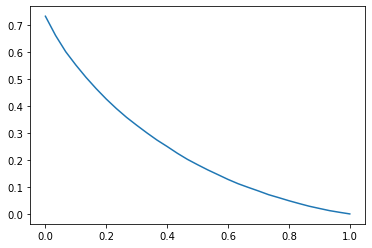

In [95]:
def brachistochrone(y):
    startingPoint = np.array([0,1])
    endingPoint = np.array([1,0])
    
    y = np.insert(y,0,startingPoint[1])
    y = np.append(y,endingPoint[1])
    
    n = len(y)
    
    deltaX = (endingPoint[0] - startingPoint[0]) / n
    x = np.linspace(startingPoint[0],endingPoint[0],n)
    h = startingPoint[1] - endingPoint[1]
    
    mu = 0.3
    f = 0
    
    for i in range(0,n-1):
        deltaY = y[i+1] - y[i]
        
        f = f + np.sqrt(deltaX**2 + deltaY**2) / (np.sqrt(h - y[i+1] - mu*x[i+1]) + np.sqrt(h - y[i] - mu*x[i]))
        
    return f
        
ystar, fstar = NelderMead(brachistochrone,np.linspace(0.9,0.1,30),
                          tol = 1e-6,
                          maxIter = 100000,
                          commentary = False,
                          TriangleOpsShow = False,
                          startingPointsStep = 0.05)

y = np.insert(ystar,0,1)
y = np.append(ystar,0)
n = len(y)
x = np.linspace(0,1,n)

plt.figure()
plt.plot(x,y)